In [1]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix,recall_score,precision_score,f1_score,fbeta_score
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
import numpy as np
import matplotlib.pyplot as plt
import pickle

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout,BatchNormalization,Flatten,Conv1D, Embedding,GlobalMaxPooling1D,Input
from tensorflow.keras.models import Sequential

#%pip install Sastrawi
#!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
#!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.id.300.vec.gz
#!gunzip cc.id.300.vec.gz  # Extract the binary file
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
combined_data = pd.read_csv('/kaggle/input/dataset-scraping-sendiri/dataset_combined_new - dataset_combined_new.csv', encoding='utf-8', index_col=False)
train_data=pd.read_csv('/kaggle/input/dataset-scraping-sendiri/train.csv')
val_data=pd.read_csv('/kaggle/input/dataset-scraping-sendiri/val.csv')
test_data=pd.read_csv('/kaggle/input/dataset-scraping-sendiri/test.csv')

In [4]:
combined_data.shape

(3895, 2)

In [5]:
#check text datatypes
combined_data.dtypes

text     object
label     int64
dtype: object

In [6]:
#Ensure string datatypes
combined_data['text']=combined_data['text'].astype(str)
train_data['text']=train_data['text'].astype(str)
val_data['text']=val_data['text'].astype(str)
test_data['text']=test_data['text'].astype(str)

In [7]:
stop_factory = StopWordRemoverFactory()
stopwords = stop_factory.get_stop_words()
custom_stopwords = ['aku', 'yg', 'kamu','gw','lu','lo','gua']
stopwords += custom_stopwords

pattern = r"[^A-Za-z ]"
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = re.sub(r"[^A-Za-z ]", "", text.lower())  # Remove non-alphabet characters
    word_list = word_tokenize(text)
    word_list = [word for word in word_list if word not in stopwords]
    return " ".join(word_list) 

In [8]:
combined_data['text'] = combined_data['text'].apply(preprocess_text)
train_data['text']=train_data['text'].apply(preprocess_text)
val_data['text']=val_data['text'].apply(preprocess_text)
test_data['text']=test_data['text'].apply(preprocess_text)

In [9]:
texts = combined_data['text'].values
labels = combined_data['label'].values

train_texts = train_data['text'].values
train_labels = train_data['label'].values

val_texts = val_data['text'].values
val_labels = val_data['label'].values

test_texts = test_data['text'].values
test_labels = test_data['label'].values

In [10]:
texts

array(['game slot online terpercaya winning sering kasih bonus',
       'raffi situs resmi slot gacor anti rungkad terbaik bandar togel terpercaya indonesia',
       'sendok bonus deposit redeposit', ..., 'kocaaakkkkk', 'panikk',
       'malah end'], dtype=object)

In [11]:
combined_data['label'].value_counts()

label
0    2661
1    1234
Name: count, dtype: int64

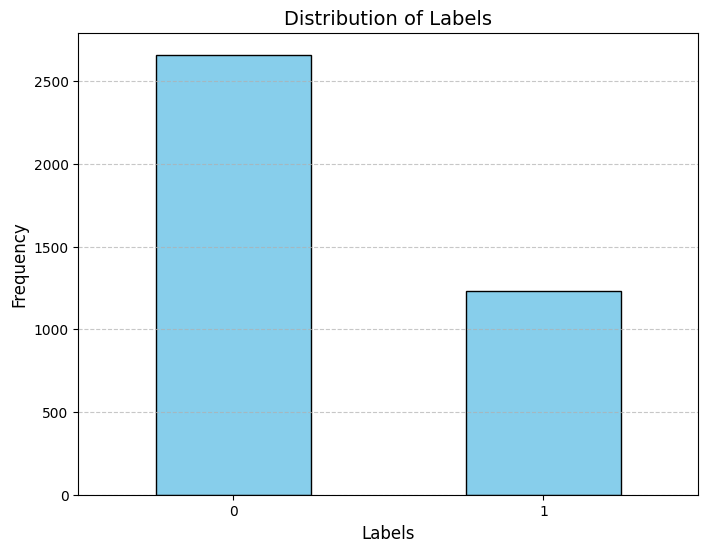

In [12]:
label_counts = combined_data['label'].value_counts()
plt.figure(figsize=(8, 6))
label_counts.plot(kind='bar', color='skyblue', edgecolor='black')

# Customize the plot
plt.title('Distribution of Labels', fontsize=14)
plt.xlabel('Labels', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

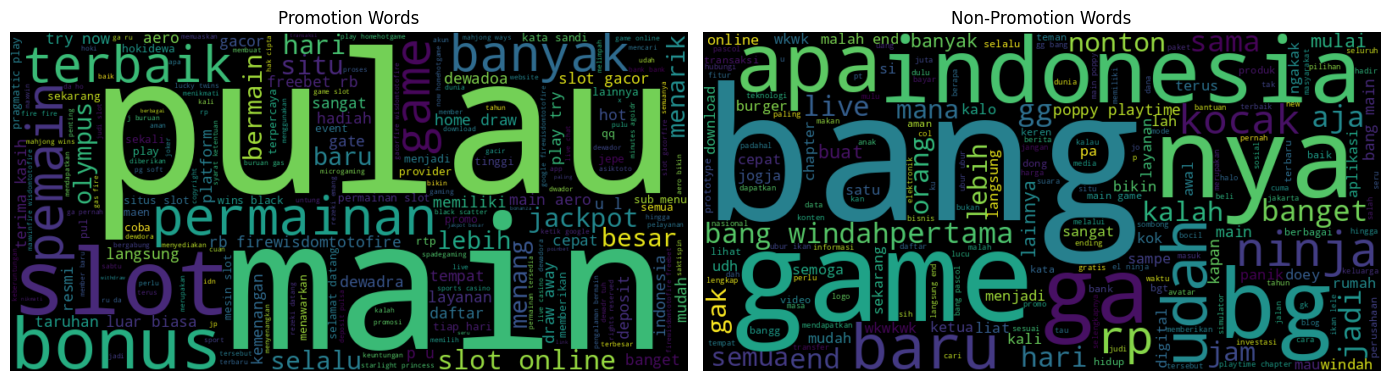

In [13]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Separate the texts by class
promotion_texts = texts[labels == 1]
non_promotion_texts = texts[labels == 0]

# Generate wordcloud for each class
promotion_wordcloud = WordCloud(width=800, height=400, background_color='black').generate(' '.join(promotion_texts))
non_promotion_wordcloud = WordCloud(width=800, height=400, background_color='black').generate(' '.join(non_promotion_texts))

# Plot the wordclouds
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

axes[0].imshow(promotion_wordcloud, interpolation='bilinear')
axes[0].set_title("Promotion Words")
axes[0].axis("off")

axes[1].imshow(non_promotion_wordcloud, interpolation='bilinear')
axes[1].set_title("Non-Promotion Words")
axes[1].axis("off")

plt.tight_layout()
plt.show()

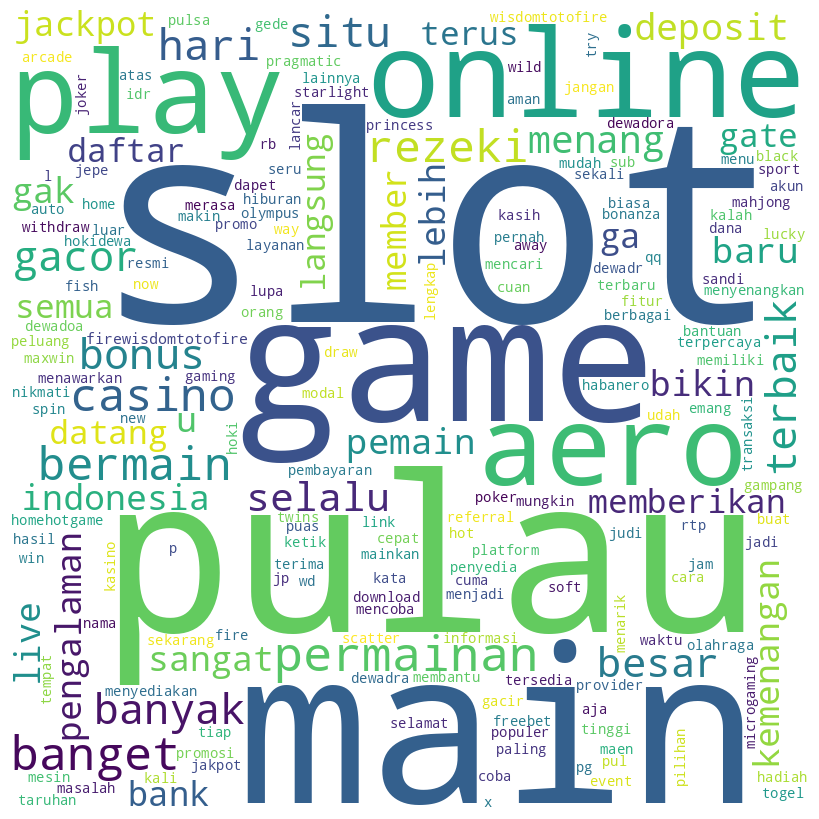

In [14]:
wordcloud = WordCloud(width=800, height=800,
                      background_color='white',
                      collocations=False,
                      min_font_size=10).generate(' '.join(promotion_texts))

# Display the word cloud using matplotlib
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [15]:
#x_train,x_temp,y_train,y_temp=train_test_split(texts,labels, test_size=0.2, random_state=42,stratify=labels)
#x_test,x_val,y_test,y_val=train_test_split(x_temp,y_temp,test_size=0.5,random_state=42,stratify=y_temp)

In [16]:
embedding_file = "cc.id.300.vec"
embedding_dict = {}

with open(embedding_file, "r", encoding="utf-8") as f:
    next(f) 
    for line in f:
        values = line.strip().split()
        word = values[0]
        vector = np.asarray(values[1:], dtype="float32")
        embedding_dict[word] = vector

In [17]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(train_texts)

vocab_size = len(tokenizer.word_index) +1

train_texts_seq = tokenizer.texts_to_sequences(train_texts)
val_texts_seq = tokenizer.texts_to_sequences(val_texts)
test_texts_seq= tokenizer.texts_to_sequences(test_texts)

MAX_LEN = 128
train_texts_padded = pad_sequences(train_texts_seq, maxlen=MAX_LEN, padding='post', truncating='post')
val_texts_padded = pad_sequences(val_texts_seq, maxlen=MAX_LEN, padding='post', truncating='post')
test_texts_padded=pad_sequences(test_texts_seq, maxlen=MAX_LEN, padding='post', truncating='post')


In [18]:
embedding_dim = 300  
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, index in tokenizer.word_index.items():
    embedding_vector = embedding_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [19]:
model = Sequential([
    Embedding(input_dim=vocab_size,output_dim=embedding_dim,weights=[embedding_matrix], trainable=True),
    
    Conv1D(filters=64, kernel_size=3, activation='relu'),

    BatchNormalization(),

    Conv1D(filters=128, kernel_size=5, activation='relu'),

    GlobalMaxPooling1D(),

    Dense(128, activation='relu'),

    Dropout(0.5),
    
    Dense(64, activation='relu'),

    Dropout(0.5),

    Dense(32, activation='relu'),

    Dropout(0.5),

    Dense(1, activation='sigmoid')

])


In [20]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5), loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │       3,025,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ ?                           │     0 (unbuilt) │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,025,500 (11.54 MB)

 Trainable params: 3,025,500 (11.54 MB)

 Non-trainable params: 0 (0.00 B)

None


In [21]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [22]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = dict(enumerate(class_weights))

class_weights

{0: 0.685027541311968, 1: 1.851150202976996}

In [23]:
history=model.fit(train_texts_padded,train_labels,epochs=100,validation_data=(val_texts_padded,val_labels),batch_size=64,callbacks=[early_stopping],class_weight=class_weights)

Epoch 1/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - accuracy: 0.4776 - loss: 1.0775 - val_accuracy: 0.5248 - val_loss: 0.6923
Epoch 2/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5027 - loss: 0.8822 - val_accuracy: 0.6035 - val_loss: 0.6920
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4986 - loss: 0.9016 - val_accuracy: 0.6210 - val_loss: 0.6916
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5037 - loss: 0.8817 - val_accuracy: 0.6531 - val_loss: 0.6907
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5132 - loss: 0.8283 - val_accuracy: 0.6676 - val_loss: 0.6901
Epoch 6/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5113 - loss: 0.7838 - val_accuracy: 0.7114 - val_loss: 0.6883
Epoch 7/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5031 - loss: 0.7822 - val_accuracy: 0.7347 - val_loss: 0.6862
Epoch 8/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5221 - loss: 0.7672 - val_accuracy: 0.7522 

In [24]:

pred=model.predict(test_texts_padded)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


In [25]:
from sklearn.metrics import precision_recall_curve, f1_score
from sklearn.metrics import average_precision_score

y_probs = pred.flatten()

precisions, recalls, thresholds = precision_recall_curve(test_labels, y_probs)

f1s = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)

best_idx = f1s.argmax()
best_threshold = thresholds[best_idx]

print(f"Best Threshold: {best_threshold:.4f}")
print(f"Best F1-Score: {f1s[best_idx]:.4f}")

ap_score = average_precision_score(test_labels, y_probs)
print(f"Average Precision (AP) Score: {ap_score:.4f}")


Best Threshold: 0.4249
Best F1-Score: 0.9399
Average Precision (AP) Score: 0.9629


Accuracy Score: 0.9678
Recall Score: 0.9348
Precision Score: 0.9451
F1 Score: 0.9399
Fbeta Score: 0.9430
Classification Report:               precision    recall  f1-score   support

           0       0.98      0.98      0.98       250
           1       0.95      0.93      0.94        92

    accuracy                           0.97       342
   macro avg       0.96      0.96      0.96       342
weighted avg       0.97      0.97      0.97       342

Confusion Matrix:



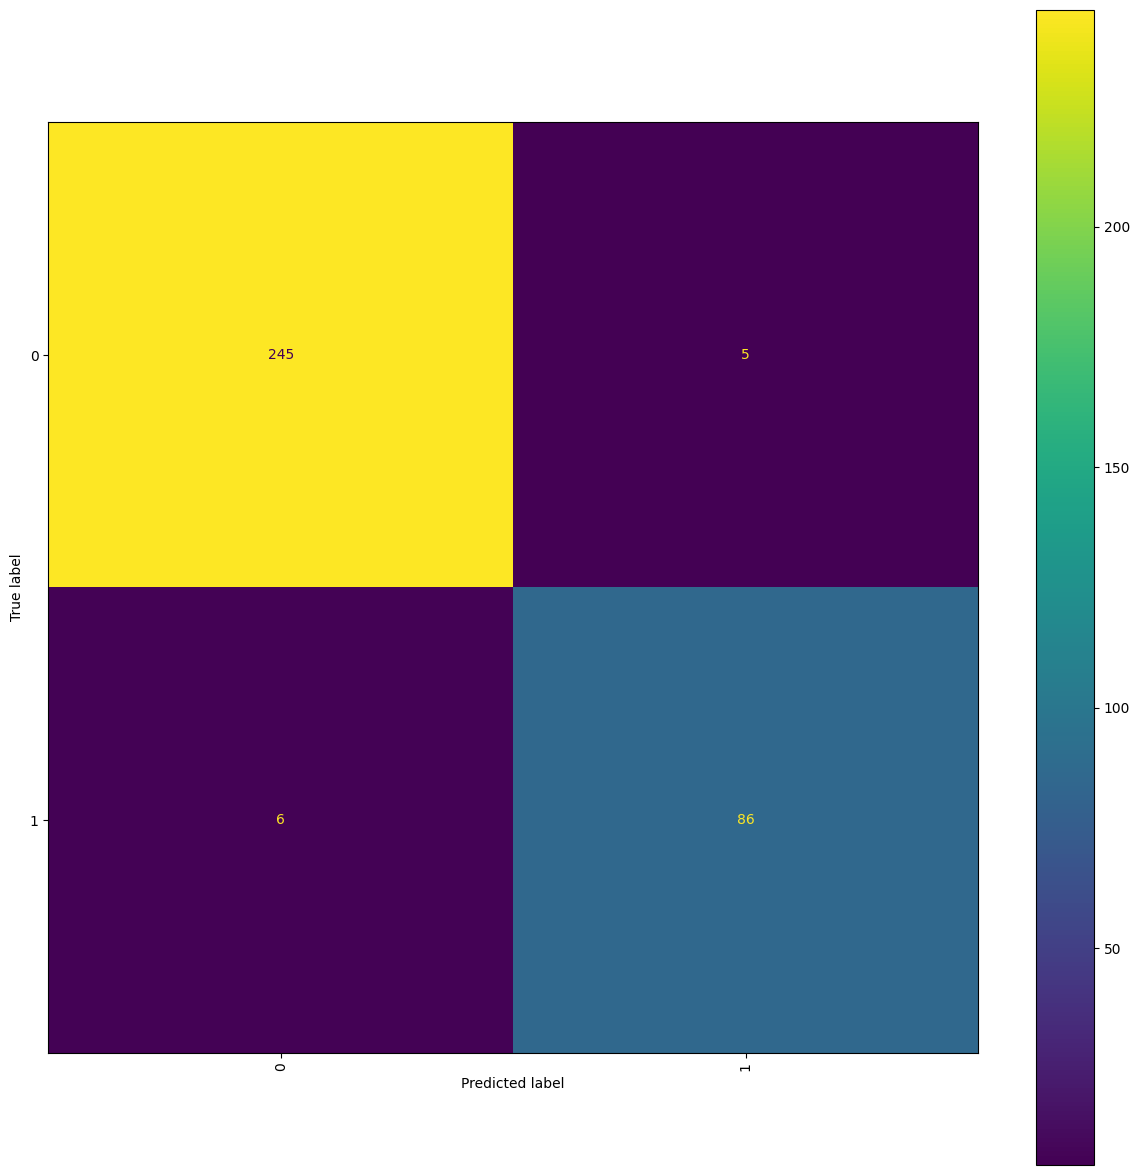

In [26]:
from sklearn.metrics import ConfusionMatrixDisplay
#pred_labels = (pred > 0.5).astype(int)  
pred_labels = [0 if pred < best_threshold else 1 for pred in pred]

print(f"Accuracy Score: {accuracy_score(test_labels, pred_labels):.4f}")
print(f"Recall Score: {recall_score(test_labels, pred_labels,average='binary'):.4f}")
print(f"Precision Score: {precision_score(test_labels, pred_labels,average='binary'):.4f}")
print(f"F1 Score: {f1_score(test_labels, pred_labels,average='binary'):.4f}")
print(f"Fbeta Score: {fbeta_score(test_labels, pred_labels,beta=0.5,average='binary',pos_label=1):.4f}")


print(f"Classification Report: {classification_report(test_labels, pred_labels)}")

display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(test_labels, pred_labels))

fig, ax = plt.subplots(figsize=(15,15))
print(f"Confusion Matrix:\n")
display.plot(ax=ax, xticks_rotation='vertical')

In [27]:
def predict_sentiment(text):
    use_text = [preprocess_text(t) for t in text]
    use_text = tokenizer.texts_to_sequences(use_text)
    use_text = pad_sequences(use_text, maxlen=MAX_LEN, padding='post', truncating='post')

    
    pred = model.predict(use_text)
    pred_labels = (pred > 0.5).astype(int)
    pred_labels = pred_labels.flatten() 
    #pred_labels = tf.argmax(pred.logits, axis=1)
    
    label_type = ['NotPromotion', 'Promotion']
    pred_labels = [label_type[i] for i in pred_labels]
    
    for index, pred in enumerate(pred_labels):
        print(f"{text[index]}: {pred}")

In [28]:
text = [
    "Aku adalah seorang mahasiswa",
    "Judi Online Disebut Masuk Tahap Sosial, Cak Imin: 8,8 Juta Pasien Minta Direhabilitasi Jumat, 15 Nov",
    "Gacor xxtoto menang pasti dibayar",
    "dp jd jt buruan gas garansi meteorwin",
    "gacor pasti menang di xxtoto",
    "top up di kantorbola pasti gampang menangnya",
    "gratis koin buruan topup di agencasinoindonesia",
    "gratis koin buruan topup di fairbet88.com, segera daftarkan akun anda",
    "DEWA-DORA tuh situs yang paling enak withdraw tiap hari! 😖 😣",
    "DEWA-DORA tuh situs yang paling gampang narik tiap hari! 😖 😣",
    "Gua setia maen di DEWADORA, tempat terbaik!",
    "kantorbola99.club - Mau Jackpot x50 x100 x500 x1000 pasti dibayar ? gabung dan Menang berapapun dibayar."
]
predict_sentiment(text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step
Aku adalah seorang mahasiswa: NotPromotion
Judi Online Disebut Masuk Tahap Sosial, Cak Imin: 8,8 Juta Pasien Minta Direhabilitasi Jumat, 15 Nov: NotPromotion
Gacor xxtoto menang pasti dibayar: Promotion
dp jd jt buruan gas garansi meteorwin: NotPromotion
gacor pasti menang di xxtoto: Promotion
top up di kantorbola pasti gampang menangnya: NotPromotion
gratis koin buruan topup di agencasinoindonesia: Promotion
gratis koin buruan topup di fairbet88.com, segera daftarkan akun anda: Promotion
DEWA-DORA tuh situs yang paling enak withdraw tiap hari! 😖 😣: Promotion
DEWA-DORA tuh situs yang paling gampang narik tiap hari! 😖 😣: Promotion
Gua setia maen di DEWADORA, tempat terbaik!: Promotion
kantorbola99.club - Mau Jackpot x50 x100 x500 x1000 pasti dibayar ? gabung dan Menang berapapun dibayar.: Promotion
